# ARIMA Model

### What is an ARIMA model?

**AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I:** Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA:** Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


##### The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.

**d:** The number of times that the raw observations are differenced, also called the degree of differencing.

**q:** The size of the moving average window, also called the order of moving average.

### Import Packages

In [11]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pmdarima.arima import auto_arima
import time

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

### Get Data

In [2]:
data_dir = "/gpfs/gpfs0/project/SDS/instructional/ds5110_sp23_finalproject/"

## ARIMA

In [3]:
agg_data_monthly = pd.read_csv(data_dir + "aggregate_data_daily.csv", parse_dates=True)
agg_data_monthly['date'] = pd.to_datetime(agg_data_monthly.date).dt.strftime("%Y-%m")
agg_data_monthly.sort_values(by='date',ascending=False)
agg_data_monthly = agg_data_monthly.groupby(["date"]).mean()
agg_data_monthly.index = pd.DatetimeIndex(agg_data_monthly.index)

In [4]:
train_len_monthly = int(len(agg_data_monthly)*0.8)

train_monthly = agg_data_monthly.close[:train_len_monthly]
test_monthly = agg_data_monthly.close[train_len_monthly:]
train_monthly.index = pd.DatetimeIndex(train_monthly.index).to_period('M')
test_monthly.index = pd.DatetimeIndex(test_monthly.index).to_period('M')

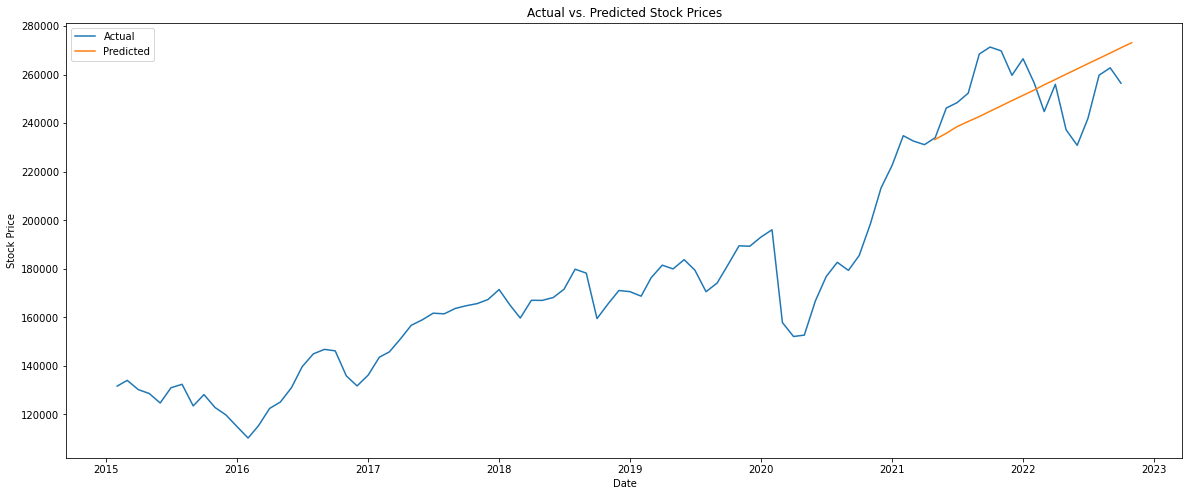

In [5]:
model_monthly = ARIMA(train_monthly, order=(3, 2, 0)) 
model_monthly = model_monthly.fit()

pred_monthly = model_monthly.predict(start=train_len_monthly, end = len(agg_data_monthly)-1, typ='levels')

# Visualize predictions and actual stock prices
plt.figure(figsize=(20,8))
plt.plot(agg_data_monthly.close, label='Actual')
plt.plot(test_monthly.index, pred_monthly, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [6]:
mse_monthly = mean_squared_error(test_monthly, pred_monthly)
mse_monthly

263612628.6570001

In [12]:
mae_monthly = mean_absolute_error(test_monthly, pred_monthly)
mae_monthly

13370.616698446696

In [9]:
model_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                   74
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -757.923
Date:                Sun, 23 Apr 2023   AIC                           1523.846
Time:                        15:27:16   BIC                           1532.952
Sample:                    02-28-2015   HQIC                          1527.471
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1995      0.052     -3.864      0.000      -0.301      -0.098
ar.L2         -0.1849      0.048     -3.833      0.000      -0.279      -0.090
ar.L3         -0.0816      0.038     -2.152      0.031      -0.156      -0.007
sigma2      7.232e+07   8.57e-11   8.44e+17      0.000    7.23e+07    7.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.95   Jarque-Bera (JB):                88.50
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -0.94
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

# Code for Model Comparison (moved to iter.py)

In [ ]:
result = pd.DataFrame({'Order' : [], 'MSE' : []})

orders_list = []

for p in range(4):
    for d in range(3):
        for q in range(12):
            orders_list.append((p, d, q))
            for x in range(5, 13, 1):
                orders_list.append((p, d, q, x))

counter = 0

for order in tqdm(orders_list):
    
    try:
        if len(order)==3:
            model_monthly = ARIMA(train_monthly, order=order) 
        else:
            model_monthly = ARIMA(train_monthly, seasonal_order=order)
            
        model_monthly = model_monthly.fit()
        pred_monthly = model_monthly.predict(start=train_len_monthly, end = len(agg_data_monthly)-1, typ='levels')
        mse_monthly = mean_squared_error(test_monthly, pred_monthly)
        
        temp = pd.DataFrame({'Order' : [order], 'MSE' : [mse_monthly]})
        result = pd.concat([result,temp])
        
    except:
        temp = pd.DataFrame({'Order' : [order], 'MSE' : [np.nan]})
        result = pd.concat([result,temp])
    
    counter += 1
    if counter % 100 == 0:
        print("Current best:", result.sort_values('MSE', na_position='last').head(1).Order[0],
             "at MSE of", result.sort_values('MSE', na_position='last').head(1).MSE[0])

In [ ]:
print("Max MSE:", result.MSE.max())
print("Min MSE:", result.MSE.min())
result.sort_values('MSE', na_position='last').head(1).MSE[0]